\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from covid.data.data import BaseData, DailyHistCT

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [3]:
con = DailyHistCT.build_con(**DailyHistCT.con_args)
dhct = DailyHistCT(spark=None, con=con)
df = dhct.read_psql().sort_values(['state', 'date'])

In [4]:
def get_diff(df, col='positive'):
    df_diff = df.set_index(['state', 'date']).loc[:,[col]].groupby(['state']).diff().reset_index()
    return df_diff.rename({col:col+"_diff"}, axis=1)

In [5]:
get_diff(df=df)

,state,date,positive_diff
0,AK,2020-03-06,NaN
1,AK,2020-03-07,NaN
2,AK,2020-03-08,NaN
3,AK,2020-03-09,NaN
4,AK,2020-03-10,NaN
...,...,...,...
20775,WY,2021-03-03,89.0
20776,WY,2021-03-04,69.0
20777,WY,2021-03-05,79.0
20778,WY,2021-03-06,0.0


In [6]:
df = df\
    .set_index(['state','date'])\
    .join(get_diff(df=df, col='positive').set_index(['state','date']), on=['state','date'])\
    .reset_index()

df.loc[:,"positive_diff_norm"] = df.loc[:,'positive_diff'] / df.loc[:,"totalTestResultsIncrease"]

In [7]:
df.describe()

,totalTestResults,totalTestsViral,pending,positive,negative,hospitalizedCurrently,recovered,death,deathIncrease,hospitalizedCumulative,...,inIcuCumulative,inIcuCurrently,negativeTestsViral,onVentilatorCumulative,onVentilatorCurrently,positiveCasesViral,positiveTestsViral,totalTestResultsIncrease,positive_diff,positive_diff_norm
count,2.061400e+04,1.447000e+04,2138.000000,2.058400e+04,1.327400e+04,17338.000000,1.200200e+04,19909.000000,20780.000000,12891.000000,...,3792.000000,11636.000000,5.057000e+03,1293.000000,9122.000000,1.411800e+04,8.991000e+03,20780.000000,20528.000000,1.928900e+04
mean,2.186918e+06,2.311679e+06,1658.945276,1.652205e+05,8.492308e+05,1190.622679,9.424961e+04,3686.051133,24.790712,11319.911489,...,1932.686709,359.618683,1.806763e+06,573.442382,151.614449,1.802168e+05,1.977723e+05,17508.388210,1400.836467,NaN
std,4.436516e+06,4.450625e+06,4671.239973,3.268324e+05,1.344999e+06,2060.088484,2.110445e+05,6283.559430,60.161081,17607.266565,...,1953.287739,594.831730,2.491664e+06,434.832480,207.797158,3.361984e+05,3.510587e+05,33595.386881,3037.866379,NaN
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,2.000000e+00,0.000000,-201.000000,1.000000,...,6.000000,0.000000,1.000000e+00,32.000000,0.000000,0.000000e+00,0.000000e+00,-130545.000000,-7757.000000,-inf
25%,1.040120e+05,1.358945e+05,43.000000,5.768250e+03,5.464725e+04,167.000000,3.379000e+03,163.000000,0.000000,1039.000000,...,499.250000,60.000000,2.929850e+05,219.000000,29.000000,1.107550e+04,1.575450e+04,1206.000000,73.000000,3.162651e-02
50%,6.552670e+05,7.386370e+05,211.000000,4.620400e+04,3.059720e+05,531.000000,1.761900e+04,1111.000000,6.000000,4965.000000,...,1294.000000,171.500000,9.228270e+05,412.000000,86.000000,7.002800e+04,6.489000e+04,6128.500000,450.500000,6.607143e-02
75%,2.264766e+06,2.511443e+06,1291.000000,1.780308e+05,1.057705e+06,1279.000000,9.315475e+04,4390.000000,24.000000,13018.500000,...,2449.500000,380.000000,2.306389e+06,818.000000,185.000000,2.048818e+05,2.237365e+05,19086.500000,1357.000000,1.319715e-01
max,4.964601e+07,4.964601e+07,64400.000000,3.501394e+06,1.018694e+07,22851.000000,2.502609e+06,54124.000000,2559.000000,89995.000000,...,9263.000000,5225.000000,1.688741e+07,1533.000000,2425.000000,3.501394e+06,2.628176e+06,473076.000000,71734.000000,inf


In [8]:
df.date.max()

Timestamp('2021-03-07 00:00:00')

In [9]:
# sparkClassPath = os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.postgresql:postgresql:42.2.14 pyspark-shell'
# spark = SparkSession\
#     .builder\
#     .appName('covid_data')\
#     .config('spark.driver.host', 'localhost')\
#     .config('spark.cores.max', '20')\
#     .getOrCreate()

In [10]:
# dhct = DailyHistCT(spark=spark)
# dhct.get_df_old()
# dhct.df_old.select(F.expr('max(date)')).show()

In [11]:
# print(dhct.api_needs_updating)

# dhct.get_df_new()
# dhct.df_new.select(F.max('date')).show()
# dhct.api_status_old.orderBy('buildTime', ascending=False).show(5, False)
# dhct.api_status_new.orderBy('buildTime', ascending=False).show(5, False)

In [12]:
def plot_single_state(state='PA', col='death', ylim=None, grid=False):
#     state_death_ts = dhct.df_old\
#     .filter(F.expr(f"state=='{state}'"))\
#     .select('date', col)\
#     .orderBy('date')

    state_death_ts = df.loc[df.state==f"{state}", ['date', col]].sort_values('date', axis=0)

    state_death = state_death_ts #state_death_ts.toPandas()
    state_death.loc[:, 'date'] = pd.to_datetime(state_death.date)
    state_death.set_index('date', inplace=True)
    state_death.sort_index(inplace=True)
    
    fig, axs = plt.subplots(1, 1, figsize=(8,8))
    fig.autofmt_xdate(rotation=45)
    dates = state_death.index.get_level_values(0).tolist()
    col_vals = state_death.loc[:,col].tolist()   
    
    axs.plot(dates, col_vals)
    if ylim:
        plt.ylim(ylim)
    if grid:
        plt.grid()

    return fig

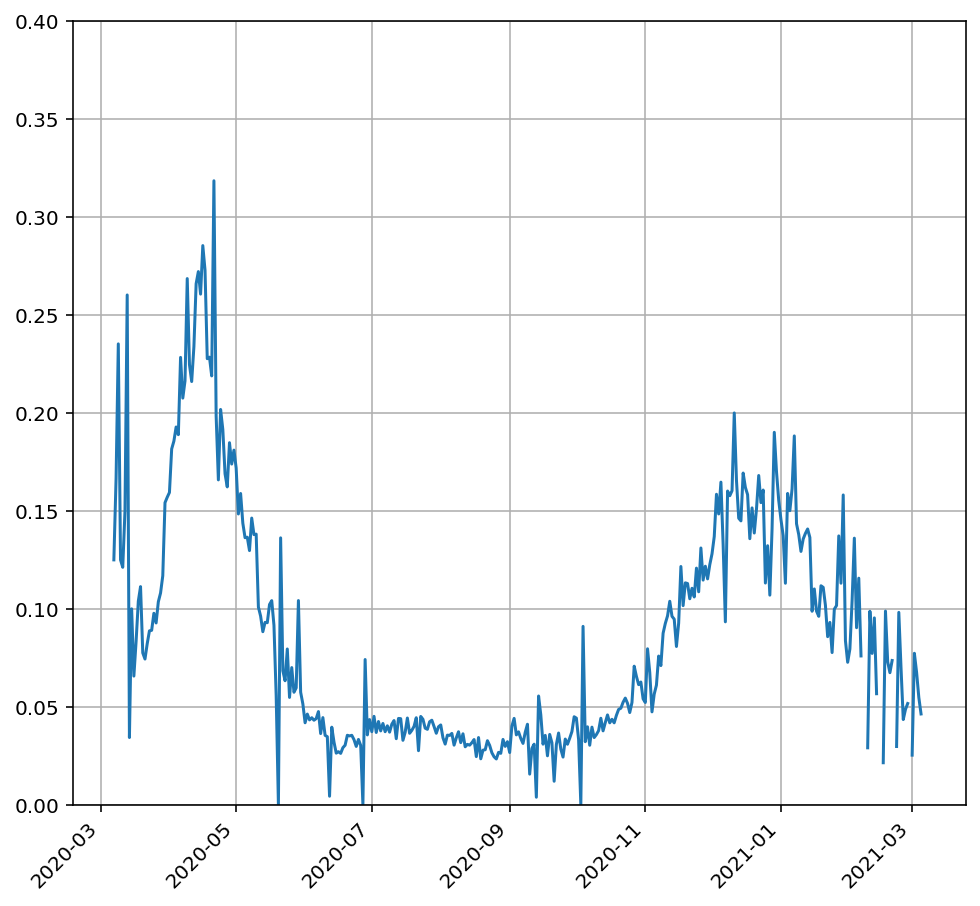

In [13]:
fig = plot_single_state(col='positive_diff_norm', ylim=[0, 0.4], grid=True)

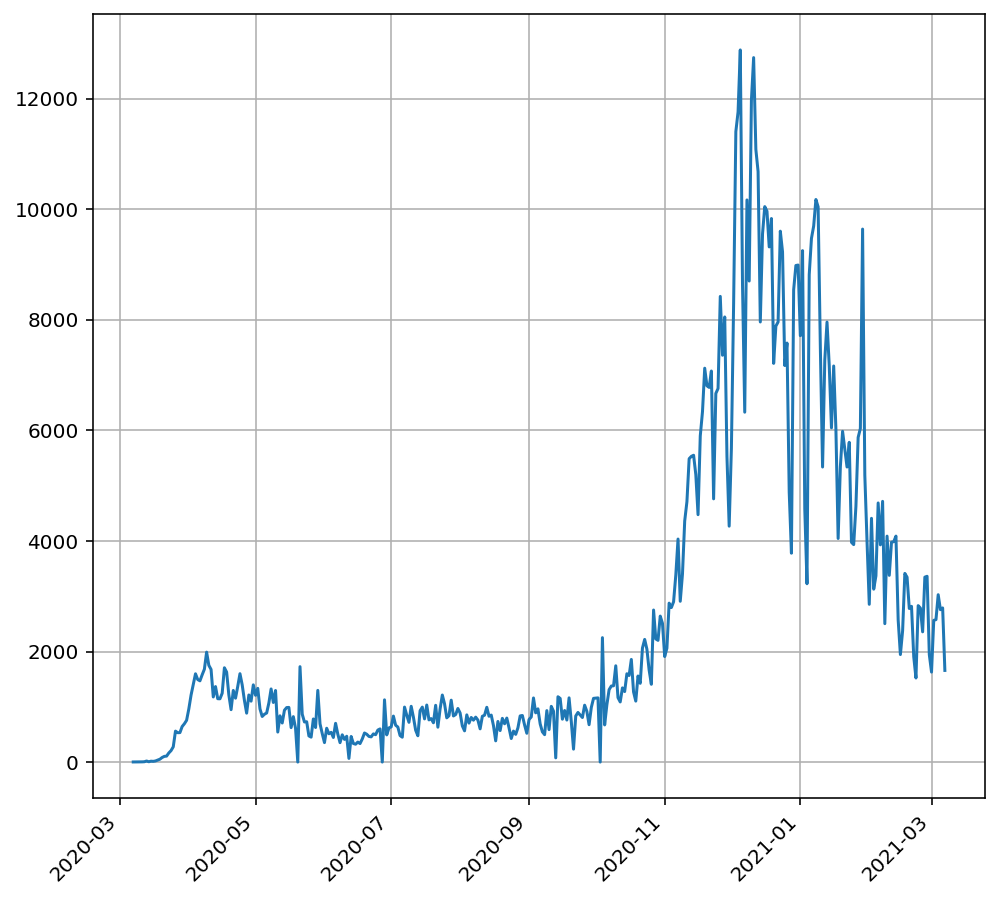

In [14]:
fig = plot_single_state(state='PA', col='positive_diff', grid=True)

In [15]:
fig.savefig("/mnt/c/Users/zerae/Desktop/test01.png", dpi=300)

In [16]:
def plot_all_states(col='deathIncrease', str_frmt='%.1f', ylim=None, grid=False):
#     state_death_ts = dhct.df_old\
#     .select('date','state', col)\
#     .orderBy('state', 'date')
    
    state_death_ts = df.loc[:, ['date', 'state', col]]

    state_death = state_death_ts #state_death_ts.toPandas()
    state_death.set_index(['state','date'], inplace=True)
    state_death.sort_index(inplace=True)

    states = state_death.index.get_level_values(0).unique().tolist()

    fig, axs = plt.subplots(9, 6, sharex=True, sharey=False, figsize=(12,12))
    fig.autofmt_xdate(rotation=45)
    for s, a in zip(states, axs.flatten()):
        sub = state_death.loc[(s,slice(None)), slice(None)]
        dates = sub.index.get_level_values(1).tolist()
        y = [x[0] for x in sub.values.tolist()]
        a.plot(dates, y, linewidth=0.75)
    #     a.legend(s, loc='upper left', markerscale=0.1)
        a.text(0.15, 0.8, s, horizontalalignment='center', transform=a.transAxes)
        a.tick_params(axis='y', labelrotation=90)
        a.yaxis.set_major_formatter(FormatStrFormatter(str_frmt))
        if ylim:
            a.set_ylim(ylim)
        if grid:
            a.grid()
    return fig
    
    

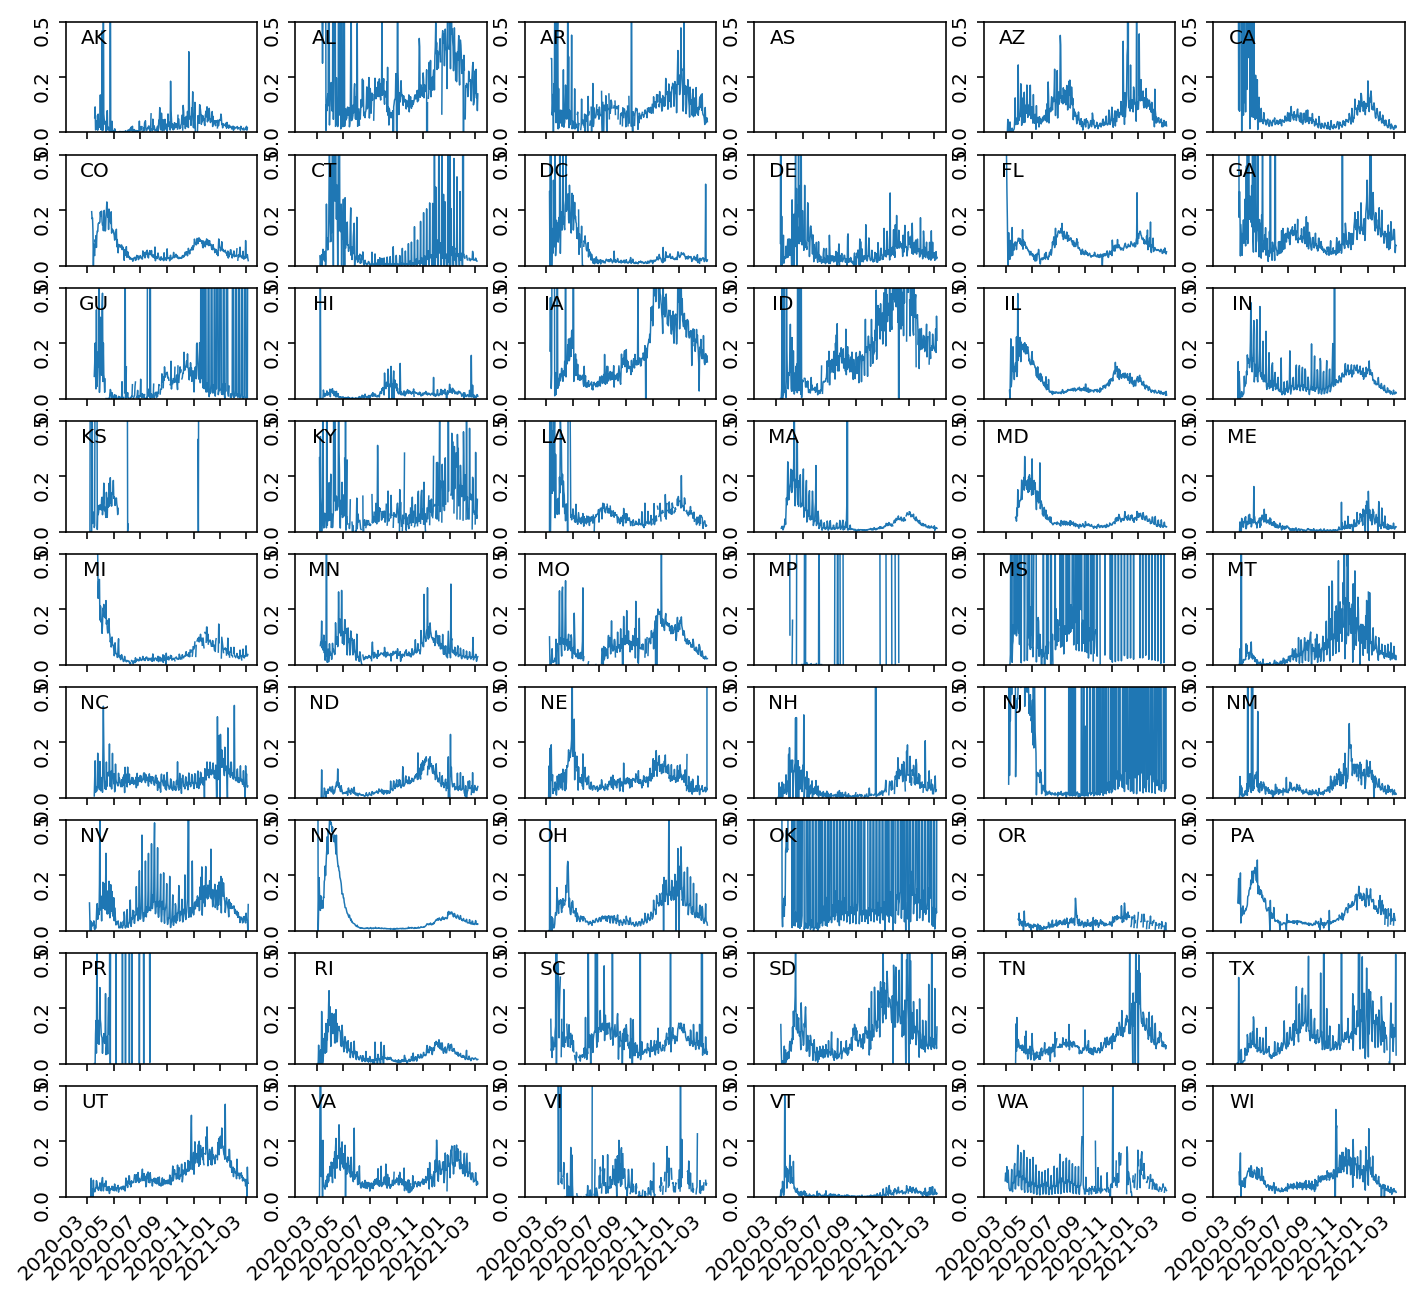

In [17]:
fig = plot_all_states(col='positive_diff_norm', ylim=[0,0.5])

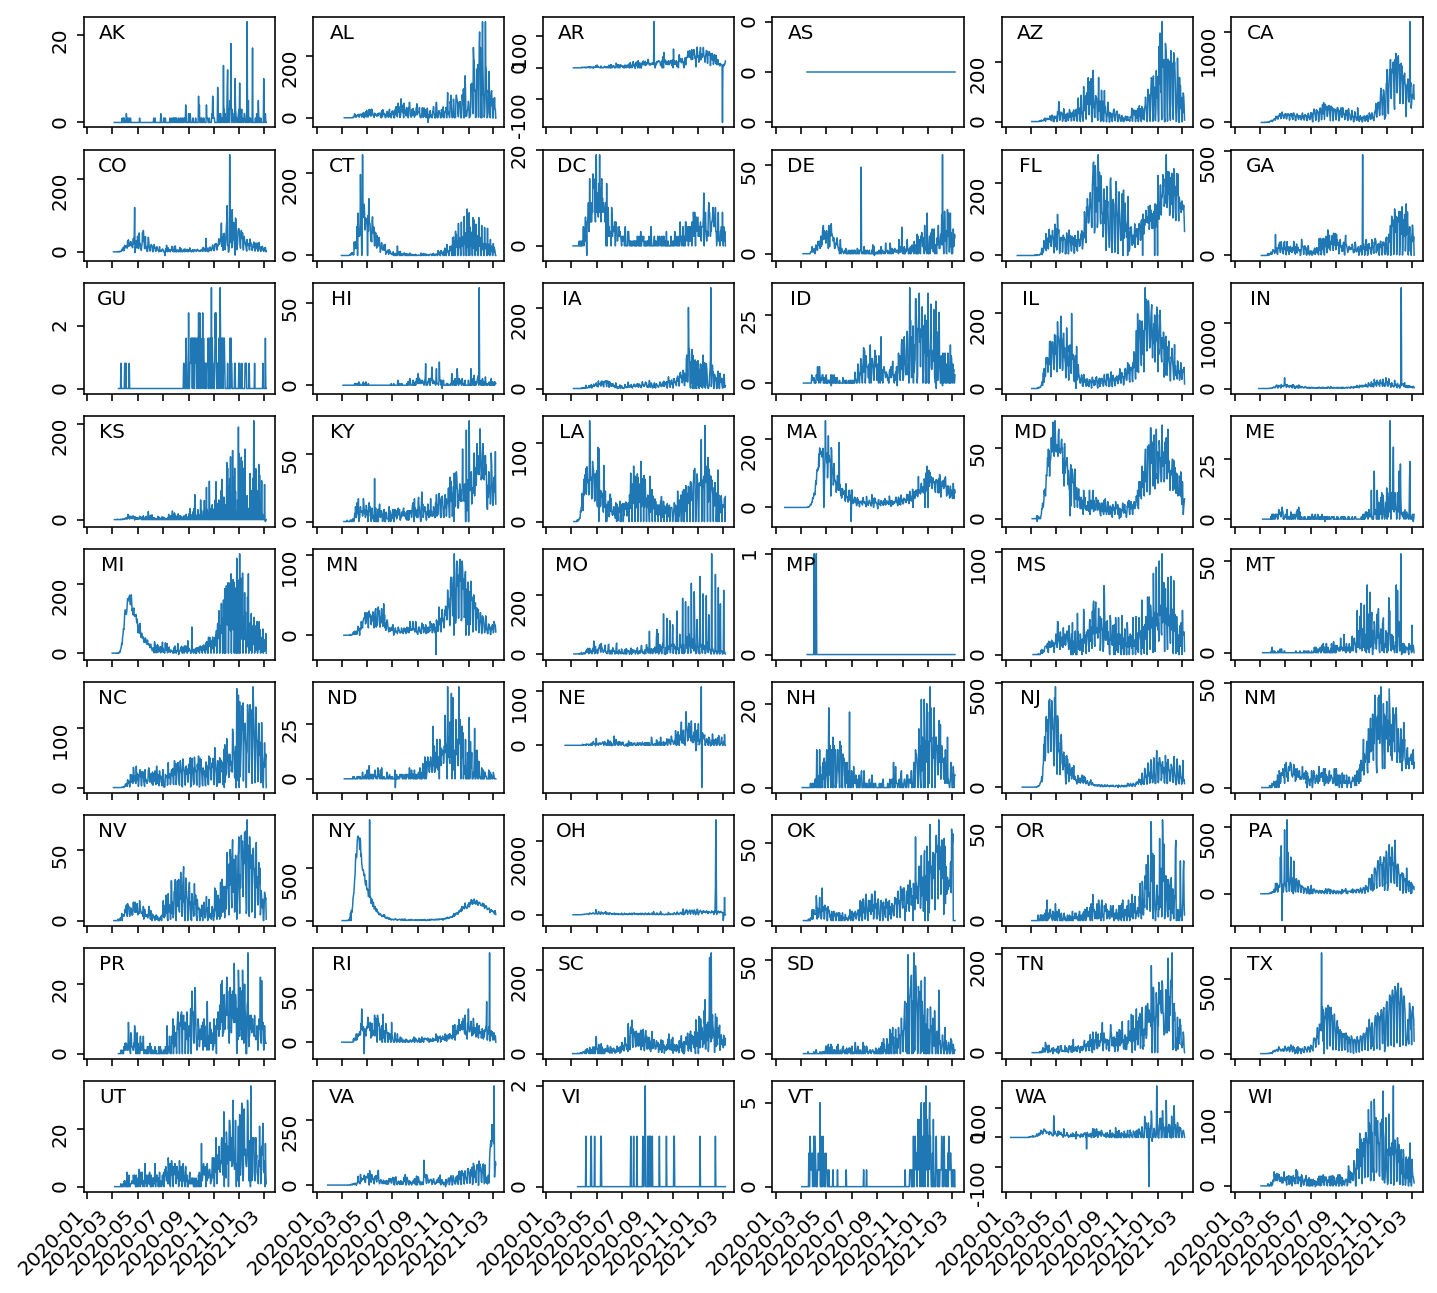

In [18]:
fig = plot_all_states(col='deathIncrease', str_frmt='%1d')

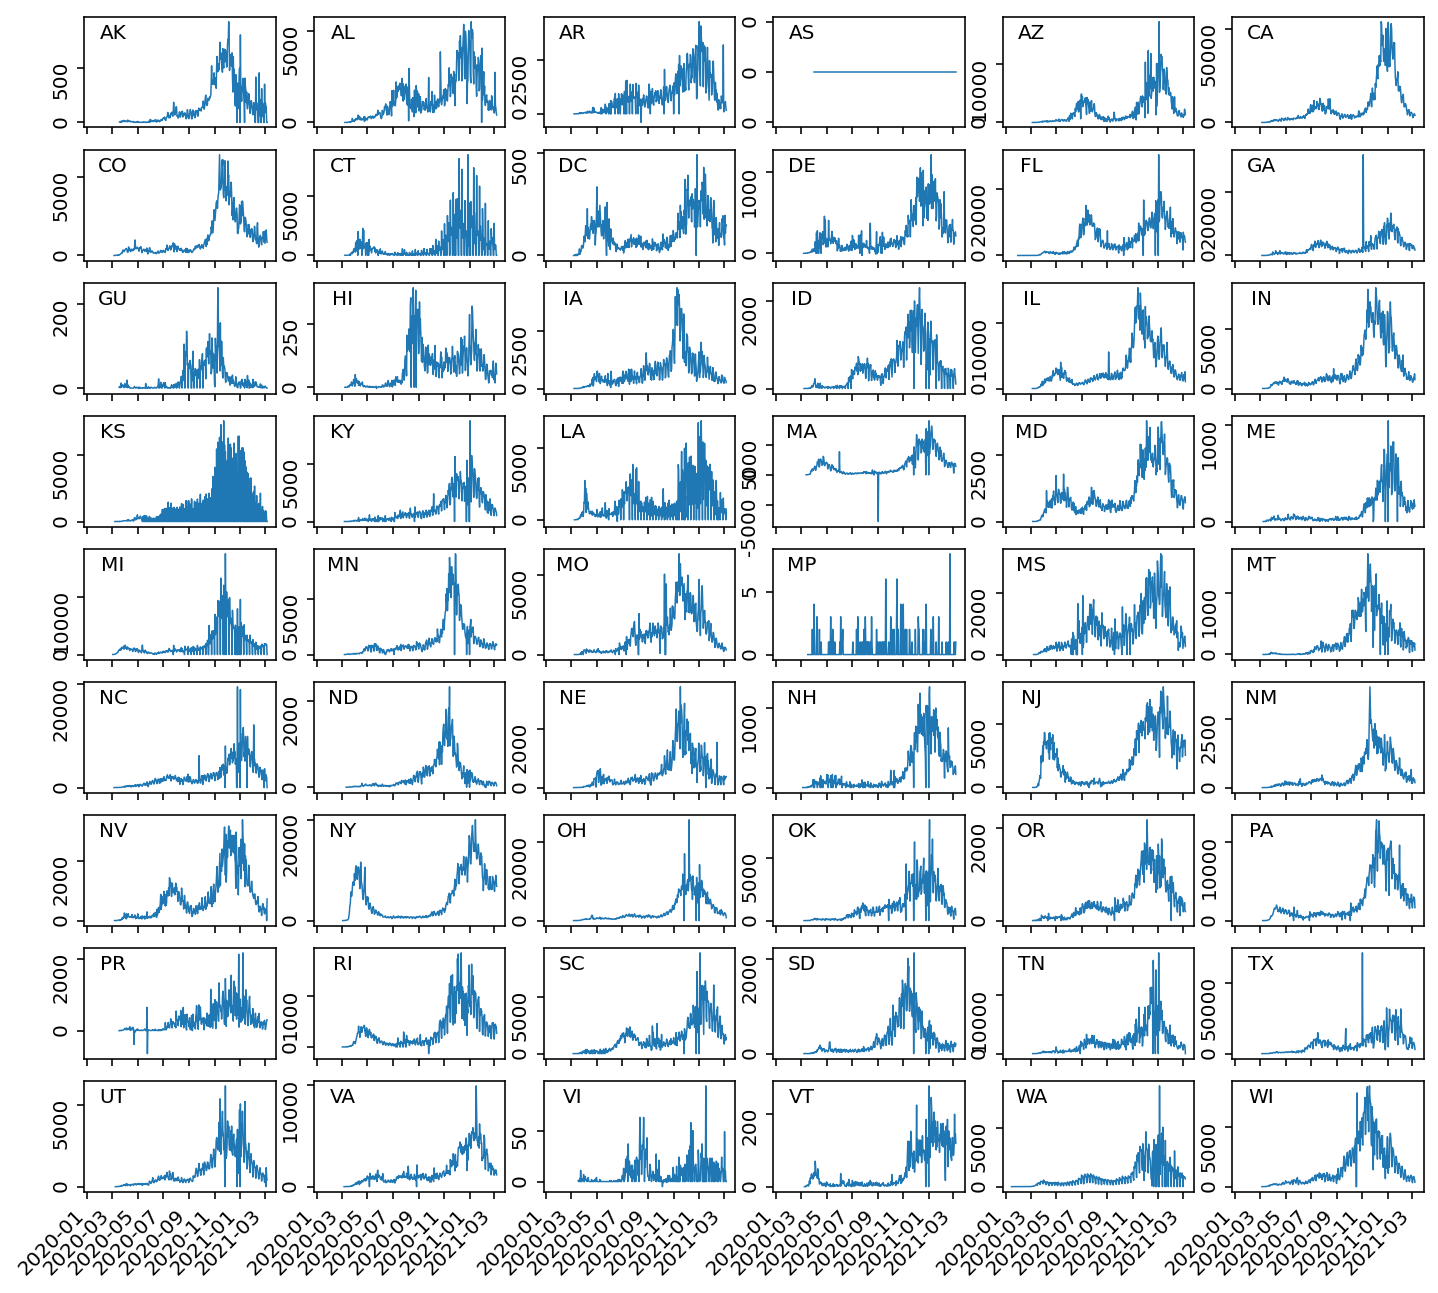

In [19]:
fig = plot_all_states(col='positive_diff', str_frmt='%1d')

In [20]:
fig.savefig("/mnt/c/Users/zerae/Desktop/test02.png", dpi=350)